In [1]:
import numpy as np
from dataloader import SISSDataset, Rescale, RandomCrop, RandomRotate, ToMultiFloatMaskValues, Normalize, FinalRoIAlignExperiment
from torchvision import transforms, models, datasets
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
import skimage
import torch
from torchvision.ops import RoIAlign, MultiScaleRoIAlign

In [2]:
def plot_img(img, label = True):
    if label:
        cmap = colors.ListedColormap(['white', 'red'])
        bounds=[0,0.5,1]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        plt.imshow(img, interpolation='nearest', origin='lower',
                            cmap=cmap, norm=norm)
    else:
        plt.imshow(img, cmap='gray')
    
    plt.show()
    
siss = SISSDataset(num_slices = 153,
            num_scans= 2,
            root_dir = Path.cwd().parents[0],
            transform = transforms.Compose([
                            Rescale(224),
                            Normalize(),
                            ToMultiFloatMaskValues()
                        ])        
       )
track_sample = siss[91]

scans, label224, label28 = track_sample
label224 = label224

Feature sizes

In [3]:
fe_size = 224//8   # (224 to 28) is 224/8 = 28
ctr = np.zeros((fe_size * fe_size, 2))
sub_sample_ratio = 224//28 # it is the height and width stride of the anchor centres. 
# we want to visit each and every point of the feature map and create a set of anchors.
# for our case, 28x28 points on the original map will be the anchor centres.

# Aspect Ratio of an anchor box is basically width/height. aspect ratio will always be 1 (square box) 
# Scales are bigger as the anchor box is from the base box (i.e. 512 x 512 box is twice as big as 256 x 256).
# for scale, its better to go at 8 times. 

import math
ar = 1.0
scale = 56/sub_sample_ratio  # to ensure that we get 25 on 112, 12.5 on 56 and 6.25 on 28

# every 1x1 pixel on the 28x28 map corresponds to 8x8 on the original image. need to get the center of every 8x8 region.
width_b = scale * math.sqrt(ar) * sub_sample_ratio 
height_b = scale * sub_sample_ratio / math.sqrt(ar)

# Generate all the center points for all the boxes.
ctr = np.zeros((fe_size * fe_size, 2))
ctr_x = np.arange(sub_sample_ratio, (fe_size+1) * sub_sample_ratio, sub_sample_ratio)
ctr_y = ctr_x.copy()

index = 0
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 0] = ctr_x[x] - sub_sample_ratio/2
        ctr[index, 1] = ctr_y[y] - sub_sample_ratio/2
        index +=1
        
anchors = np.zeros((fe_size * fe_size, 4))
anchors[:, 0] = ctr[:, 0] - height_b / 2.
anchors[:, 1] = ctr[:, 1] - width_b / 2.
anchors[:, 2] = ctr[:, 0] + height_b / 2.
anchors[:, 3] = ctr[:, 1] + width_b / 2.

In [4]:
valid_anchor_boxes_indices = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= 224) &
        (anchors[:, 3] <= 224)
    )[0]
valid_anchor_boxes = anchors[valid_anchor_boxes_indices]
# Out of 784 anchor boxes, choosing only the set of valid anchor boxes
len(valid_anchor_boxes_indices)


484

In [5]:
# Select 10 shots overall.
max_boxes = 10
mask = label224[0].numpy()


If there is some lesion on the mask, that is, if  

In [6]:
len(np.unique(mask)) != 1 

True

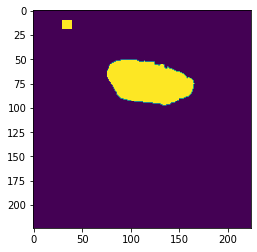

In [7]:
mask[10:20, 30:40] = 1.0
plt.imshow(mask)
masked_labels = skimage.measure.label(mask)

# instances are encoded as different colors
obj_ids = np.unique(masked_labels)
# first id is the background, so remove it
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set
# of binary masks
masks = masked_labels == obj_ids[:, None, None]

# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[0])
    xmax = np.max(pos[0])
    ymin = np.min(pos[1])
    ymax = np.max(pos[1])
    boxes.append([xmin, ymin, xmax, ymax])


Testing the Box Masks

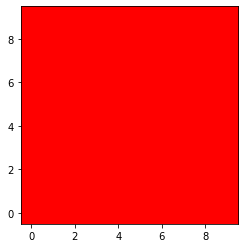

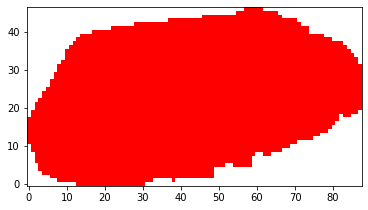

In [8]:
# make a color map of fixed colors
# tell imshow about color map so that only set colors are used
x1, y1, x2, y2 = boxes[0]
plot_img(mask[x1:x2+1, y1:y2+1])

x1, y1, x2, y2 = boxes[1]
plot_img(mask[x1:x2+1, y1:y2+1])


In [9]:
#only choose the top 10 boxes from this.
ious = np.empty((len(valid_anchor_boxes), len(boxes)), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(boxes):
        xb1, yb1, xb2, yb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1 +1) * \
(inter_x2 - inter_x1 +1)
            iou = iter_area / \
(anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
            
        ious[num1, num2] = iou

# choose the highest valued bounding boxes
patches_for_objs = max_boxes //num_objs
maxarg_ious = np.argsort(ious, axis=0)[::-1]

selected_ious_args = []
for obj in range(num_objs):
    obj_max_indices = maxarg_ious[:patches_for_objs, obj].tolist()
    maxarg_ious = np.delete(maxarg_ious, obj_max_indices, axis=0)
    selected_ious_args.extend(obj_max_indices)
    
# Return, the selected anchor boxes coords and the class_labels
sel_anchors = valid_anchor_boxes[selected_ious_args]
sel_anchors
class_labels = [1.0] * max_boxes


Else if there is no lesion on the image, first, get the MRI brain x1,y1,x2,y2. 
Now proceed to get the other areas.

In [10]:
# box_for_scan_area
x1_scan, y1_scan, x2_scan, y2_scan = [50, 50, 200, 200]

# filter valid bounding boxes 
valid_anchor_boxes_indices = np.where(
        (valid_anchor_boxes[:, 0] >= x1_scan) &
        (valid_anchor_boxes[:, 1] >= y1_scan) &
        (valid_anchor_boxes[:, 2] <= x2_scan) &
        (valid_anchor_boxes[:, 3] <= y2_scan)
    )[0]

valid_anchor_boxes[np.random.choice(valid_anchor_boxes_indices, max_boxes)]
class_labels = [0.0] * max_boxes

In [11]:
sel_anchors

array([[  0.,   0.,  56.,  56.],
       [  8.,  24.,  64.,  80.],
       [  8.,   8.,  64.,  64.],
       [  8.,  16.,  64.,  72.],
       [  8.,   0.,  64.,  56.],
       [ 48.,  88., 104., 144.],
       [ 48.,  96., 104., 152.],
       [ 48., 104., 104., 160.],
       [ 40.,  80.,  96., 136.],
       [ 40.,  88.,  96., 144.]])

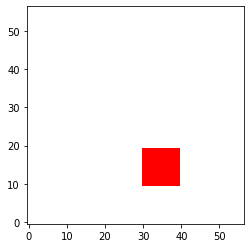

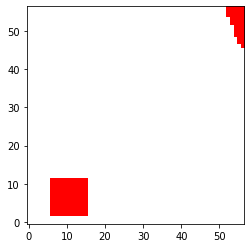

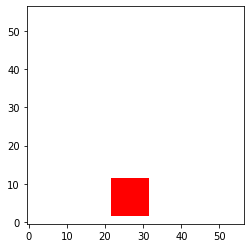

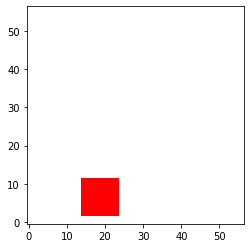

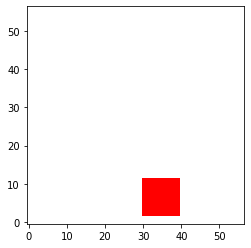

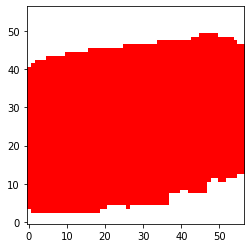

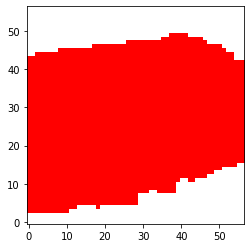

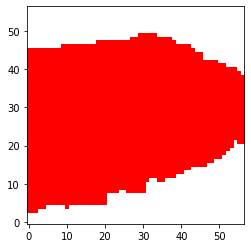

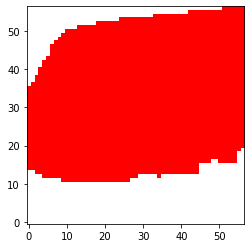

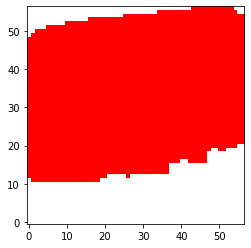

In [12]:
for anchor in sel_anchors:    
    x1, y1, x2, y2 = anchor.astype(int)
    plot_img(mask[x1:x2+1, y1:y2+1])

In [13]:
selected_ious_args

[0, 25, 23, 24, 22, 143, 144, 145, 120, 121]

In [14]:
sorted_ious = np.sort(ious, axis=0)[::-1]
sorted_indices = np.argsort(ious, axis=0)[::-1]

In [15]:
scans.shape

torch.Size([4, 224, 224])

In [16]:
cornerVal = scans[0, 0, 0]
pos = np.where(scans[0, :, :]!= cornerVal)
xmin = np.min(pos[0])
xmax = np.max(pos[0])
ymin = np.min(pos[1])
ymax = np.max(pos[1])

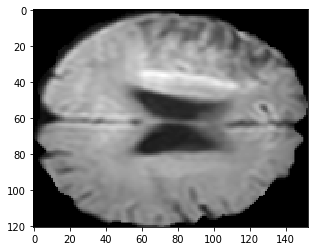

In [17]:
plot_img(scans[0, xmin:xmax, ymin:ymax], label= False)

In [18]:
x1, y1, x2, y2 = sel_anchors[0]

In [19]:
def list_to_batched(batch_size, anchors):
    batch_indices = np.zeros((batch_size, 1))
    out = np.concatenate((batch_indices, anchors), axis=-1).astype(np.float32)
    return torch.from_numpy(out)

rois = list_to_batched(max_boxes, sel_anchors)

rois = [torch.from_numpy(sel_anchors.astype(np.float32))]

mask = label224.unsqueeze(dim=0)
roi_align = RoIAlign((60, 28), spatial_scale=1.0, sampling_ratio=2)

In [20]:
import numpy as np
from dataloader import SISSDataset, Rescale, RandomCrop, RandomRotate, ToMultiFloatMaskValues, Normalize, FinalRoIAlignExperiment
from torchvision import transforms, models, datasets
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
import skimage
import torch
from torchvision.ops import RoIAlign, MultiScaleRoIAlign

scale = Rescale(int(1.05 * 230))
crop = RandomCrop(224)
rotate = RandomRotate(20.0)
norm = Normalize()
exp5_final_roialign = FinalRoIAlignExperiment() 
tupled_float_regress_masks = ToMultiFloatMaskValues() 

composed = transforms.Compose([scale,
                               rotate,
                               crop,
                               norm])

composed_for_valset = transforms.Compose([
    Rescale(224),
    norm,
    tupled_float_regress_masks
])


In [21]:
# train dataset
train_scans = 2
val_scans = 1
batch_size = 4
train_dataset = SISSDataset(num_slices=153,
                            num_scans=train_scans,
                            root_dir=Path.cwd().parents[0],
                            transform=composed)

# val dataset
val_dataset = SISSDataset(num_slices=153,
                          num_scans=val_scans,
                          root_dir=Path.cwd().parents[0],
                          transform=composed_for_valset,
                          train=False
                          )

datasets = {
    'train': train_dataset,
    'val': val_dataset
}

# pdb.set_trace()

train_dataloader = torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size, shuffle=True,
                                               num_workers=10)
val_dataloader = torch.utils.data.DataLoader(datasets['val'], batch_size=10, shuffle=True, num_workers=10)


In [22]:
def show_single_img(image, label):
    """Show image"""
    cmap = 'gray'
    if label:
        cmap = 'binary'
    plt.imshow(image, cmap = cmap)


def viz_sample(sample):
    fig = plt.figure(figsize=(20, 5))
    # fig.suptitle('Lesion Properties')

    for slice_, scan in enumerate(['DWI', 'FLAIR', 'T1', 'T2', 'Lesion Mask']):
        ax = plt.subplot(1, 5, slice_ + 1)
        show_single_img(sample[:, :, slice_], scan == 'label')
        plt.tight_layout()
        ax.set_title(scan)
        ax.axis('off')
    plt.show()

In [23]:
idx = np.random.randint(0, 153* 2)
# for i in range(2*153):
#     viz_sample(train_dataset[i])

In [24]:
def get_valid_anchor_boxes():

    fe_size = 224 // 8  # (224 to 28) is 224/8 = 28
    ctr = np.zeros((fe_size * fe_size, 2))
    sub_sample_ratio = 224 // 28  # it is the height and width stride of the anchor centres.
    # we want to visit each and every point of the feature map and create a set of anchors.
    # for our case, 28x28 points on the original map will be the anchor centres.

    # Aspect Ratio of an anchor box is basically width/height. aspect ratio will always be 1 (square box)
    # Scales are bigger as the anchor box is from the base box (i.e. 512 x 512 box is twice as big as 256 x 256).
    # for scale, its better to go at 8 times.

    import math
    ar = 1.0
    scale = 56 / sub_sample_ratio  # to ensure that we get 25 on 112, 12.5 on 56 and 6.25 on 28

    # every 1x1 pixel on the 28x28 map corresponds to 8x8 on the original image. need to get the center of every 8x8 region.
    width_b = scale * math.sqrt(ar) * sub_sample_ratio
    height_b = scale * sub_sample_ratio / math.sqrt(ar)

    # Generate all the center points for all the boxes.
    ctr = np.zeros((fe_size * fe_size, 2))
    ctr_x = np.arange(sub_sample_ratio, (fe_size + 1) * sub_sample_ratio, sub_sample_ratio)
    ctr_y = ctr_x.copy()

    index = 0
    for x in range(len(ctr_x)):
        for y in range(len(ctr_y)):
            ctr[index, 0] = ctr_x[x] - sub_sample_ratio / 2
            ctr[index, 1] = ctr_y[y] - sub_sample_ratio / 2
            index += 1

    anchors = np.zeros((fe_size * fe_size, 4))
    anchors[:, 0] = ctr[:, 0] - height_b / 2.
    anchors[:, 1] = ctr[:, 1] - width_b / 2.
    anchors[:, 2] = ctr[:, 0] + height_b / 2.
    anchors[:, 3] = ctr[:, 1] + width_b / 2.
    # %%
    valid_anchor_boxes_indices = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= 224) &
        (anchors[:, 3] <= 224)
    )[0]
    valid_anchor_boxes = anchors[valid_anchor_boxes_indices]

    return valid_anchor_boxes.astype(np.float32)

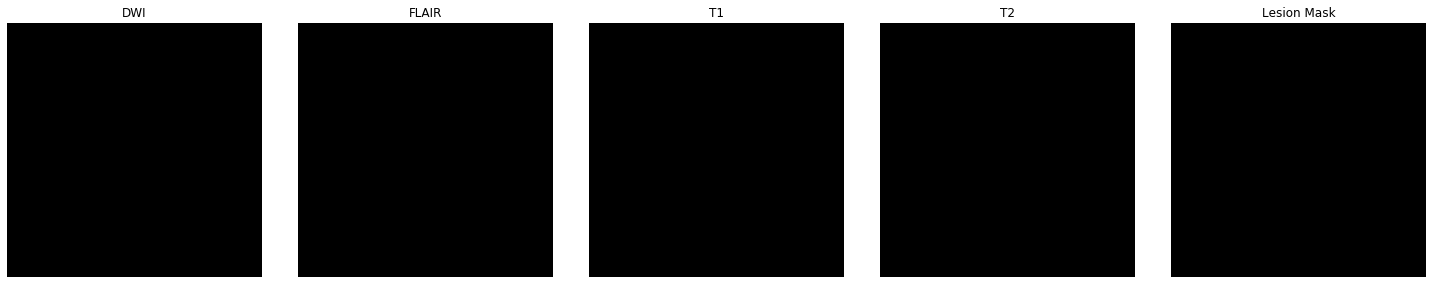

In [25]:
viz_sample(train_dataset[0])

In [26]:
valid_anchor_boxes = get_valid_anchor_boxes()

In [27]:
sample = train_dataset[0]
# scans and the labelled mask are in (4, 224, 224) and (1,224,224)
scans, label224 = sample[:, :, :-1], sample[:, :, -1]

# consistent datatypes
scans, label224 = scans.astype(np.float32), label224.astype(np.bool).astype(np.float32)

# get the data objs into an object of shape (4, h, w) and (1, h, w)
scans, label224 = scans.transpose((2, 0, 1)), label224[np.newaxis,...]

In [28]:
def get_max_ious_boxes_labels(scans, label224):
    max_boxes = 10
    mask = label224

    # If there is some lesion on the mask, that is, if
    if len(np.unique(mask)) != 1:
        masked_labels = skimage.measure.label(mask)

        # instances are encoded as different colors
        obj_ids = np.unique(masked_labels)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = masked_labels == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[0])
            xmax = np.max(pos[0])
            ymin = np.min(pos[1])
            ymax = np.max(pos[1])
            boxes.append([xmin, ymin, xmax, ymax])

        # only choose the top 10 boxes from this.
        ious = np.empty((len(valid_anchor_boxes), len(boxes)), dtype=np.float32)
        ious.fill(0)
        for num1, i in enumerate(valid_anchor_boxes):
            xa1, ya1, xa2, ya2 = i
            anchor_area = (ya2 - ya1) * (xa2 - xa1)
            for num2, j in enumerate(boxes):
                xb1, yb1, xb2, yb2 = j
                box_area = (yb2 - yb1) * (xb2 - xb1)
                inter_x1 = max([xb1, xa1])
                inter_y1 = max([yb1, ya1])
                inter_x2 = min([xb2, xa2])
                inter_y2 = min([yb2, ya2])
                if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                    iter_area = (inter_y2 - inter_y1 + 1) * \
                                (inter_x2 - inter_x1 + 1)
                    iou = iter_area / \
                          (anchor_area + box_area - iter_area)
                else:
                    iou = 0.

                ious[num1, num2] = iou

        # choose the highest valued bounding boxes
        patches_for_objs = max_boxes // num_objs
        maxarg_ious = np.argsort(ious, axis=0)[::-1]

        selected_ious_args = []
        for obj in range(num_objs):
            obj_max_indices = maxarg_ious[:patches_for_objs, obj].tolist()
            maxarg_ious = np.delete(maxarg_ious, obj_max_indices, axis=0)
            selected_ious_args.extend(obj_max_indices)

        # Return, the selected anchor boxes coords and the class_labels
        sel_anchors = valid_anchor_boxes[selected_ious_args]
        # and the all ones class labels
        class_labels = [1.0] * max_boxes

        return sel_anchors, class_labels

    # so there's no lesion at all in any part of the mask
    else:
        # box_for_scan_area
        cornerVal = scans[0, 0, 0]
        pos = np.where(scans[0, :, :] != cornerVal)
        if len(pos[0]):
            x1_scan = np.min(pos[0])
            x2_scan = np.max(pos[0])
            y1_scan = np.min(pos[1])
            y2_scan = np.max(pos[1])
        else:
            x1_scan, y1_scan, x2_scan, y2_scan = [0, 0, 223, 223]

        # filter valid bounding boxes
        valid_anchor_boxes_indices = np.where(
            (valid_anchor_boxes[:, 0] >= x1_scan) &
            (valid_anchor_boxes[:, 1] >= y1_scan) &
            (valid_anchor_boxes[:, 2] <= x2_scan) &
            (valid_anchor_boxes[:, 3] <= y2_scan)
        )[0]

        sel_anchors = valid_anchor_boxes[np.random.choice(valid_anchor_boxes_indices, max_boxes)]
        class_labels = [0.0] * max_boxes

        return sel_anchors, class_labels

In [29]:
anchor_boxes, class_labels = get_max_ious_boxes_labels(scans, label224)

In [30]:
class_labels

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

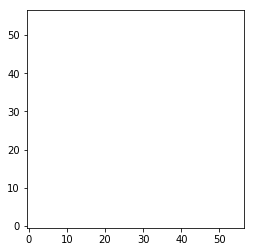

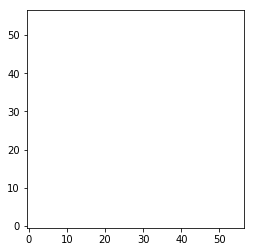

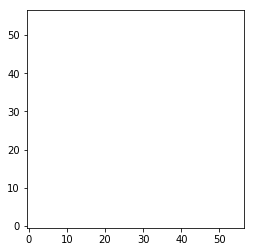

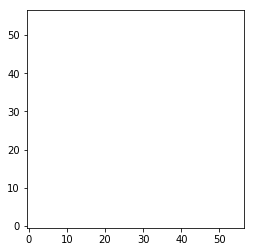

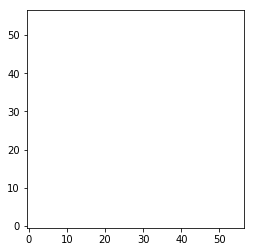

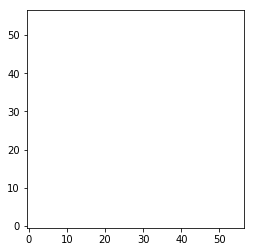

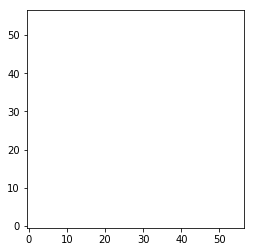

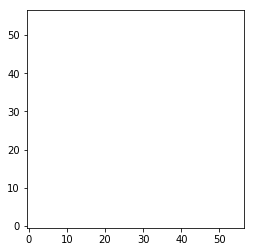

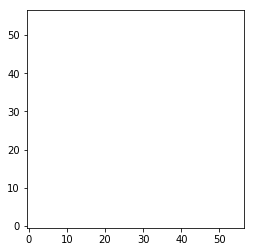

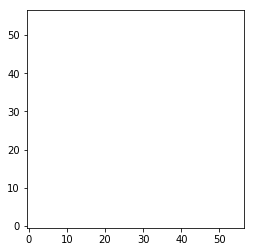

In [34]:
mask = label224[0]
for anchor in anchor_boxes:    
    x1, y1, x2, y2 = anchor.astype(int)
    plot_img(mask[x1:x2+1, y1:y2+1], label=True)

In [31]:
anchor_boxes

array([[152.,  96., 208., 152.],
       [ 56.,  48., 112., 104.],
       [ 40.,  80.,  96., 136.],
       [ 48.,  16., 104.,  72.],
       [ 56.,  80., 112., 136.],
       [ 96.,  64., 152., 120.],
       [136., 136., 192., 192.],
       [104., 160., 160., 216.],
       [  0.,  40.,  56.,  96.],
       [152., 160., 208., 216.]], dtype=float32)

In [32]:
scans, label224 = torch.from_numpy(scans), torch.from_numpy(label224)

In [33]:
cut_boxes = torch.from_numpy(anchor_boxes)

In [35]:
scale_base_roi_align = RoIAlign((56, 56), spatial_scale=1.0, sampling_ratio=2)  # base map is of size 56x56
scale_1_roi_align = RoIAlign((28, 28), spatial_scale=1.0, sampling_ratio=2)     # wil look as 28x28 on the 112x112 image
scale_2_roi_align = RoIAlign((14, 14), spatial_scale=1.0, sampling_ratio=2)     # will look at 14x14 on the 56x56 image
scale_3_roi_align = RoIAlign((7, 7), spatial_scale=1.0, sampling_ratio=2)      # will look at 7x7 on the 28x28 image

In [39]:
label224.unsqueeze(dim=0).dtype

torch.float32

In [40]:
cut_boxes.dtype

torch.float32

In [41]:
base, scale1, scale2, scale3 = scale_base_roi_align(label224.unsqueeze(dim=0), [cut_boxes]), \
                               scale_1_roi_align(label224.unsqueeze(0), [cut_boxes]), \
                               scale_2_roi_align(label224.unsqueeze(0), [cut_boxes]), \
                               scale_3_roi_align(label224.unsqueeze(0), [cut_boxes])

In [64]:
class FinalRoIAlignExperiment(object):

    def __init__(self):
        self.valid_anchor_boxes = self.get_valid_anchor_boxes().astype(np.float32)
        # extracting RoI of size 56x56 on 224x224
        self.scale_base_roi_align = RoIAlign((56, 56), spatial_scale=1.0, sampling_ratio=2)  # base map is of size 56x56
        self.scale_1_roi_align = RoIAlign((28, 28), spatial_scale=1.0, sampling_ratio=2)     # wil look as 28x28 on the 112x112 image
        self.scale_2_roi_align = RoIAlign((14, 14), spatial_scale=1.0, sampling_ratio=2)     # will look at 14x14 on the 56x56 image
        self.scale_3_roi_align = RoIAlign((7, 7), spatial_scale=1.0, sampling_ratio=2)      # will look at 7x7 on the 28x28 image

    def get_valid_anchor_boxes(self):

        fe_size = 224 // 8  # (224 to 28) is 224/8 = 28
        ctr = np.zeros((fe_size * fe_size, 2))
        sub_sample_ratio = 224 // 28  # it is the height and width stride of the anchor centres.
        # we want to visit each and every point of the feature map and create a set of anchors.
        # for our case, 28x28 points on the original map will be the anchor centres.

        # Aspect Ratio of an anchor box is basically width/height. aspect ratio will always be 1 (square box)
        # Scales are bigger as the anchor box is from the base box (i.e. 512 x 512 box is twice as big as 256 x 256).
        # for scale, its better to go at 8 times.

        import math
        ar = 1.0
        scale = 56 / sub_sample_ratio  # to ensure that we get 25 on 112, 12.5 on 56 and 6.25 on 28

        # every 1x1 pixel on the 28x28 map corresponds to 8x8 on the original image. need to get the center of every 8x8 region.
        width_b = scale * math.sqrt(ar) * sub_sample_ratio
        height_b = scale * sub_sample_ratio / math.sqrt(ar)

        # Generate all the center points for all the boxes.
        ctr = np.zeros((fe_size * fe_size, 2))
        ctr_x = np.arange(sub_sample_ratio, (fe_size + 1) * sub_sample_ratio, sub_sample_ratio)
        ctr_y = ctr_x.copy()

        index = 0
        for x in range(len(ctr_x)):
            for y in range(len(ctr_y)):
                ctr[index, 0] = ctr_x[x] - sub_sample_ratio / 2
                ctr[index, 1] = ctr_y[y] - sub_sample_ratio / 2
                index += 1

        anchors = np.zeros((fe_size * fe_size, 4))
        anchors[:, 0] = ctr[:, 0] - height_b / 2.
        anchors[:, 1] = ctr[:, 1] - width_b / 2.
        anchors[:, 2] = ctr[:, 0] + height_b / 2.
        anchors[:, 3] = ctr[:, 1] + width_b / 2.
        # %%
        valid_anchor_boxes_indices = np.where(
            (anchors[:, 0] >= 0) &
            (anchors[:, 1] >= 0) &
            (anchors[:, 2] <= 224) &
            (anchors[:, 3] <= 224)
        )[0]
        valid_anchor_boxes = anchors[valid_anchor_boxes_indices]

        return valid_anchor_boxes

    def iou(self, box1, box2):
        xa1, ya1, xa2, ya2 = box1
        anchor_area = (ya2 - ya1) * (xa2 - xa1)
        xb1, yb1, xb2, yb2 = box2
        box_area = (yb2 - yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1 + 1) * \
                        (inter_x2 - inter_x1 + 1)
            iou = iter_area / \
                  (anchor_area + box_area - iter_area)
        else:
            iou = 0.
        return iou
        
    def get_max_ious_boxes_labels(self, scans, label224):
        max_boxes = 10
        mask = label224

        # If there is some lesion on the mask, that is, if
        if len(np.unique(mask)) != 1:
            masked_labels = skimage.measure.label(mask)

            # instances are encoded as different colors
            obj_ids = np.unique(masked_labels)
            # first id is the background, so remove it
            obj_ids = obj_ids[1:]

            # split the color-encoded mask into a set
            # of binary masks
            masks = masked_labels == obj_ids[:, None, None]

            # get bounding box coordinates for each mask
            num_objs = len(obj_ids)
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[0])
                xmax = np.max(pos[0])
                ymin = np.min(pos[1])
                ymax = np.max(pos[1])
                boxes.append([xmin, ymin, xmax, ymax])

            # only choose the top 10 boxes from this.
            ious = np.empty((len(self.valid_anchor_boxes), len(boxes)), dtype=np.float32)
            ious.fill(0)
            for num1, i in enumerate(self.valid_anchor_boxes):
                for num2, j in enumerate(boxes):
                    ious[num1, num2] = self.iou(box1, box2)

            # choose the highest valued bounding boxes
            patches_for_objs = max_boxes // num_objs
            maxarg_ious = np.argsort(ious, axis=0)[::-1]

            selected_ious_args = []
            for obj in range(num_objs):
                obj_max_indices = maxarg_ious[:patches_for_objs, obj].tolist()
                maxarg_ious = np.delete(maxarg_ious, obj_max_indices, axis=0)
                selected_ious_args.extend(obj_max_indices)

            # Return, the selected anchor boxes coords and the class_labels
            sel_anchors = self.valid_anchor_boxes[selected_ious_args]
            # and the all ones class labels
            class_labels = [1.0] * max_boxes

            return sel_anchors, class_labels

        # so there's no lesion at all in any part of the mask
        else:
            # box_for_scan_area
            cornerVal = scans[0, 0, 0]
            pos = np.where(scans[0, :, :] != cornerVal)
            if len(pos[0]):
                x1_scan = np.min(pos[0])
                x2_scan = np.max(pos[0])
                y1_scan = np.min(pos[1])
                y2_scan = np.max(pos[1])
            else:
                x1_scan, y1_scan, x2_scan, y2_scan = [0, 0, 223, 223]

            # filter valid bounding boxes
            valid_anchor_boxes_indices = np.where(
                (valid_anchor_boxes[:, 0] >= x1_scan) &
                (valid_anchor_boxes[:, 1] >= y1_scan) &
                (valid_anchor_boxes[:, 2] <= x2_scan) &
                (valid_anchor_boxes[:, 3] <= y2_scan)
            )[0]

            sel_anchors = valid_anchor_boxes[np.random.choice(valid_anchor_boxes_indices, max_boxes)]
            class_labels = [0.0] * max_boxes

            return sel_anchors, class_labels

    def __call__(self, sample):

        # scans and the labelled mask are in (4, 224, 224) and (1,224,224)
        scans, label224 = sample[:, :, :-1], sample[:, :, -1]

        # consistent datatypes
        scans, label224 = scans.astype(np.float32), label224.astype(np.float32)

        # get the data objs into an object of shape (4, h, w) and (1, h, w)
        scans, label224 = scans.transpose((2, 0, 1)), label224[np.newaxis,...]

        # get 10 anchor boxes formatted.
        anchor_boxes, class_labels = self.get_max_ious_boxes_labels(scans, label224)

        scans, label224 = torch.from_numpy(scans), torch.from_numpy(label224)

        # image of size 224.
        #every anchor box has a size of 56x56
        cut_boxes = torch.from_numpy(anchor_boxes)
        base, scale1, scale2, scale3 = self.scale_base_roi_align(label224.unsqueeze(dim=0), [cut_boxes]), \
                                       self.scale_1_roi_align(label224.unsqueeze(0), [cut_boxes]), \
                                       self.scale_2_roi_align(label224.unsqueeze(0), [cut_boxes]), \
                                       self.scale_3_roi_align(label224.unsqueeze(0), [cut_boxes])
        # will return boxes of shape (batch_size, 1, h, w)

        # items to return from here, are the anchor boxes for all the cuts, the class_labels, the image scan 224,
        # the anchor cut labels of 56(base), 28 for 112, 14 for 56x56, 7 for 28x28

        return cut_boxes, class_labels, scans, (base, scale1, scale2, scale3)



In [65]:
exp5 = FinalRoIAlignExperiment()

In [67]:
exp5.get_max_ious_boxes_labels(scans, label224)

(array([[144., 136., 200., 192.],
        [  0.,  80.,  56., 136.],
        [ 40.,  40.,  96.,  96.],
        [ 40., 160.,  96., 216.],
        [112.,  80., 168., 136.],
        [160.,  40., 216.,  96.],
        [  0.,  40.,  56.,  96.],
        [ 24.,  96.,  80., 152.],
        [112., 120., 168., 176.],
        [144.,  48., 200., 104.]], dtype=float32),
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [68]:
composed_transform = transforms.Compose([scale,
                               rotate,
                               crop,
                               norm])

In [69]:
dataset = SISSDataset(
                      num_slices=153,
                      num_scans=val_scans,
                      root_dir=Path.cwd().parents[0],
                      transform=composed_transform,
                      train=False
                        )

In [70]:
sample = dataset[0]

# scans and the labelled mask are in (4, 224, 224) and (1,224,224)
scans, label224 = sample[:, :, :-1], sample[:, :, -1]

# consistent datatypes
scans, label224 = scans.astype(np.float32), label224.astype(np.float32)

# get the data objs into an object of shape (4, h, w) and (1, h, w)
scans, label224 = scans.transpose((2, 0, 1)), label224[np.newaxis,...]

In [71]:
scans.shape

(4, 224, 224)

In [72]:
label224.shape

(1, 224, 224)

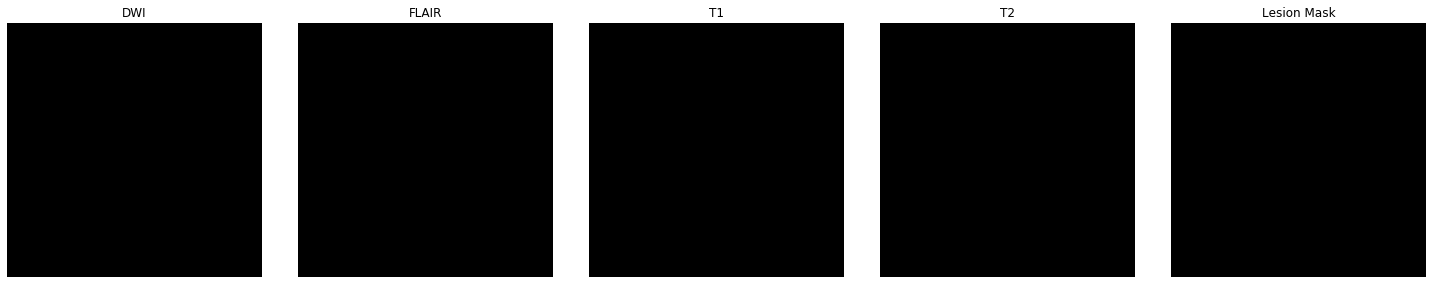

In [73]:
viz_sample(sample)

In [75]:
# get 10 anchor boxes formatted.
anchor_boxes, class_labels = exp5.get_max_ious_boxes_labels(scans, label224)

In [78]:
# image of size 224.
#every anchor box has a size of 56x56
cut_boxes = torch.from_numpy(anchor_boxes)
base, scale1, scale2, scale3 = exp5.scale_base_roi_align(label224.unsqueeze(dim=0), [cut_boxes]), \
                               exp5.scale_1_roi_align(label224.unsqueeze(0), [cut_boxes]), \
                               exp5.scale_2_roi_align(label224.unsqueeze(0), [cut_boxes]), \
                               exp5.scale_3_roi_align(label224.unsqueeze(0), [cut_boxes])

In [94]:
exp5 = FinalRoIAlignExperiment()
final_transform = transforms.Compose([scale,
                               rotate,
                               crop,
                               norm,
                               exp5])
final_dataset = SISSDataset(
                    num_slices = 153, 
                    num_scans = val_scans,
                    root_dir = Path.cwd().parents[0],
                    transform = final_transform,
                    train= False
                )